In [1]:
import pandas_ta as ta
import pandas as pd
import plotly.graph_objects as go
from backtesting import Backtest, Strategy
from sqzmom import sqzmom
import seaborn as sns
import matplotlib.pyplot as plt


In [11]:
ONE_MIN = "frd_sample_etf_SPY/SPY_1min_sample.csv"
df = pd.read_csv(ONE_MIN)
df = df.rename(columns={"open": "Open", "close": "Close", "high": "High", "low": "Low", "volume":"Volume"})
df.set_index(pd.DatetimeIndex(df["timestamp"]), inplace=True)

df["SMA"]=ta.sma(df.Close, length=200)
df['RSI']=ta.rsi(df.Close, length=10)
df['ATR']=ta.atr(df.High, df.Low, df.Close, length=7)

df = sqzmom(df)

In [5]:
fig = go.Figure(data=[go.Candlestick(x=df.index,
                open=df['Open'],
                high=df['High'],
                low=df['Low'],
                close=df['Close'])
                ])

fig.update_layout(
    title='SPY 5 Minute Chart',
    yaxis_title='SPY Price',
    shapes = [dict(
        x0='2023-12-01', x1='2023-12-09', y0=0, y1=1, xref='x', yref='paper',
        line_width=2)]
)


fig.show()

In [12]:
selected_columns = ['squeeze_on', 'squeeze_off', 'no_squeeze']

def combine_to_enum(row):
    for i, val in enumerate(selected_columns):
        if row[val] == 1:
            return i

    return None

# Applying the function to the DataFrame
df['Total Signal'] = df.apply(combine_to_enum, axis=1)

In [7]:
def SIGNAL():
    return df['Total Signal']

In [21]:
class MyStrat(Strategy):
    mysize = 0.99
    slcoef = 1.2 #1.3
    TPSLRatio = 2 # 1.8
    def init(self):
        super().init()
        self.signal1 = self.I(SIGNAL)

    def next(self):
        super().next()
        slatr = self.slcoef*self.data.ATR[-1]
        TPSLRatio = self.TPSLRatio

        if len(self.trades)>0:
            if self.trades[-1].is_long and self.data.RSI[-1]>=90:
                self.trades[-1].close()
            elif self.trades[-1].is_short and self.data.RSI[-1]<=10:
                self.trades[-1].close()
        
        # Buy signal (squeeze on)
        if self.signal1==0 and len(self.trades)==0:
            sl1 = self.data.Close[-1] - slatr
            tp1 = self.data.Close[-1] + slatr*TPSLRatio
            self.buy(sl=sl1, tp=tp1, size=self.mysize)
        
        # Sell signal (squeeze off)
        elif self.signal1==1 and len(self.trades)==0:         
            sl1 = self.data.Close[-1] + slatr
            tp1 = self.data.Close[-1] - slatr*TPSLRatio
            self.sell(sl=sl1, tp=tp1, size=self.mysize)

bt = Backtest(df, MyStrat, cash=500, margin=1/30, commission=0.00)
stats, heatmap = bt.optimize(slcoef=[i/10 for i in range(10, 16)],
                    TPSLRatio=[i/10 for i in range(10, 31)], 
                    maximize='Return [%]', max_tries=300,
                        random_state=0,
                        return_heatmap=True)
stats

/Users/dylantom/Documents/options/venv/lib/python3.10/site-packages/backtesting/backtesting.py:1375: UserWarning:

For multiprocessing support in `Backtest.optimize()` set multiprocessing start method to 'fork'.



Start                     2023-11-27 04:00:00
End                       2023-12-11 19:50:00
Duration                     14 days 15:50:00
Exposure Time [%]                   91.180706
Equity Final [$]                   592.533176
Equity Peak [$]                    910.689805
Return [%]                          18.506635
Buy & Hold Return [%]                1.651624
Return (Ann.) [%]                56366.583977
Volatility (Ann.) [%]          2751584.532612
Sharpe Ratio                         0.020485
Sortino Ratio                      337.962399
Calmar Ratio                       1485.78353
Max. Drawdown [%]                  -37.937279
Avg. Drawdown [%]                   -2.778801
Max. Drawdown Duration        5 days 20:14:00
Avg. Drawdown Duration        0 days 04:13:00
# Trades                                  574
Win Rate [%]                        34.843206
Best Trade [%]                       0.475041
Worst Trade [%]                      -0.25457
Avg. Trade [%]                    

In [22]:
stats["_strategy"]

<Strategy MyStrat(slcoef=1.5,TPSLRatio=1.9)>

In [23]:
bt.run()
bt.plot()

/Users/dylantom/Documents/options/venv/lib/python3.10/site-packages/backtesting/_plotting.py:250: BokehDeprecationWarning:

Passing lists of formats for DatetimeTickFormatter scales was deprecated in Bokeh 3.0. Configure a single string format for each scale

/Users/dylantom/Documents/options/venv/lib/python3.10/site-packages/backtesting/_plotting.py:250: UserWarning:

DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'

/Users/dylantom/Documents/options/venv/lib/python3.10/site-packages/backtesting/_plotting.py:250: BokehDeprecationWarning:

Passing lists of formats for DatetimeTickFormatter scales was deprecated in Bokeh 3.0. Configure a single string format for each scale

/Users/dylantom/Documents/options/venv/lib/python3.10/site-packages/backtesting/_plotting.py:250: UserWarning:

DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'

/Users/dylantom/Documents/options/venv/lib/python3.10/site-packages/ba

GridPlot(id='p2068', ...)

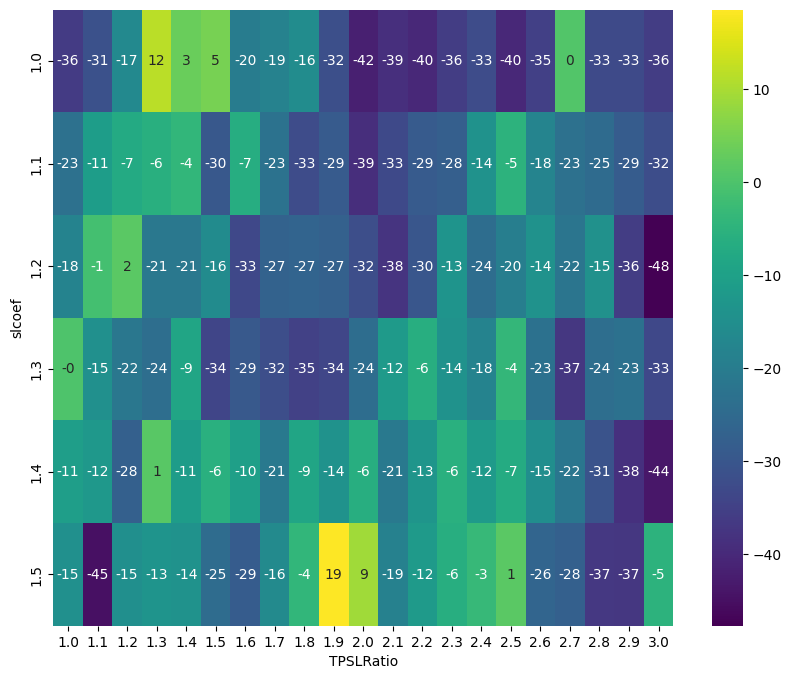

In [24]:
# Convert multiindex series to dataframe
heatmap_df = heatmap.unstack()
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_df, annot=True, cmap='viridis', fmt='.0f')
plt.show()

In [27]:
stats["_trades"]

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Duration
0,-32,20,20,454.2300,454.230000,-0.000000,-0.000000,2023-11-27 04:36:00,2023-11-27 04:36:00,0 days 00:00:00
1,-32,21,25,454.1700,454.000000,5.440000,0.000374,2023-11-27 04:43:00,2023-11-27 04:59:00,0 days 00:16:00
2,-33,26,27,454.0700,454.280000,-6.930000,-0.000462,2023-11-27 05:00:00,2023-11-27 05:07:00,0 days 00:07:00
3,-32,28,29,454.2100,454.396137,-5.956375,-0.000410,2023-11-27 05:09:00,2023-11-27 05:11:00,0 days 00:02:00
4,-32,30,34,454.4900,454.590000,-3.200000,-0.000220,2023-11-27 05:13:00,2023-11-27 05:19:00,0 days 00:06:00
...,...,...,...,...,...,...,...,...,...,...
569,41,8177,8179,462.0450,461.848860,-8.041740,-0.000425,2023-12-11 15:58:00,2023-12-11 16:00:00,0 days 00:02:00
570,41,8181,8181,462.0006,461.642469,-14.683351,-0.000775,2023-12-11 16:02:00,2023-12-11 16:02:00,0 days 00:00:00
571,40,8182,8280,461.9500,461.563060,-15.477617,-0.000838,2023-12-11 16:03:00,2023-12-11 18:16:00,0 days 02:13:00
572,-39,8281,8281,461.8400,461.840000,-0.000000,-0.000000,2023-12-11 18:17:00,2023-12-11 18:17:00,0 days 00:00:00
